In [4]:
import boto3, pytz
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import io

In [5]:
TARGET_BUCKET = 'masc12-roundshot-img-storage'
WEBCAM_CSV = "webcams-2024-10-14-v2.csv"
OUTLIER_CSV = "image-size-outliers.csv"

In [6]:
session = boto3.Session(profile_name='exxeta-admin')
bucket = session.resource('s3').Bucket(TARGET_BUCKET)
lambda_client = session.client('lambda')
s3_client = session.client('s3')

In [14]:
removefolder = ['test', 'stg-power', '_faulty', 'rorschacherberg_copy', 'kronberg_temp', '_copy',\
                '_copy/rorschacherberg_copy', '_copy/kronberg_temp', '_copy/kronberg_temp2']

In [15]:
def get_files_and_folders_from_s3():
    files = [obj.key for obj in bucket.objects.all() if obj.key.endswith('.jpg')]
    for rmf in removefolder:
        files = [f for f in files if not f.startswith(f'{rmf}/')]
    folders = [obj.key[:-1] for obj in bucket.objects.all() if obj.key.endswith('/')]
    folders = [f for f in folders if f not in removefolder]

    return files, folders

def get_date_range_from(start, end):
    try:
        start = pytz.timezone('Europe/Zurich').localize(start)
    except ValueError:
        pass

    try:
        end = pytz.timezone('Europe/Zurich').localize(end)
    except ValueError:
        pass
    
    daterange = []
    while start <= end:
        if dt.time(4, 0) <= start.time() < dt.time(23, 0):
            daterange.append(start)
        start += dt.timedelta(minutes=10)
    return daterange

def get_date_range_yesterday():
    now = get_nearest_10_minute() - dt.timedelta(days=1)
    start = now.replace(hour=4, minute=0, second=0, microsecond=0) # yesterday 4:00
    end = now.replace(hour=22, minute=50, second=0, microsecond=0) # yesterday 23:00
    return get_date_range_from(start, end)

def get_nearest_10_minute() -> dt.datetime:
    now = dt.datetime.now(pytz.timezone('Europe/Zurich'))
    now = now - dt.timedelta(minutes=now.minute % 10,
                             seconds=now.second,
                             microseconds=now.microsecond)
    return now

def filter_relevant_files(allfiles, daterange):
    """
    Returns a list of files that are within the daterange
    """

    tz = pytz.timezone('Europe/Zurich')
    start_date = daterange[0]
    end_date = daterange[-1]
    return [
        f for f in allfiles
        if start_date <= tz.localize(dt.datetime.strptime(f.split('/')[-1][:-4], '%Y-%m-%d_%H-%M-%S')) <= end_date
    ]

def get_csv_from_s3(bucket:str, csv:str) -> pd.DataFrame:
    csv_object = s3_client.get_object(Bucket=bucket, Key=csv)
    csv_content = csv_object['Body'].read().decode('utf-8')
    webcams_df = pd.read_csv(io.StringIO(csv_content), sep=';', encoding='utf-8')
    return webcams_df

def calculate_metrics(files:list, folders:list, daterange:list) -> dict:
    # for each webcam, alphabetical order
    # - timestamp of first image of the day
    # - timestamp of last image of the day
    # - number of images taken vs. expected & percentage
    # - missing images between first and last image

    # days in daterange
    days = len(daterange) / 114
    if days % 1 != 0:
        raise ValueError("Date range is weird", days)
    
    effective_target = 52*days # 52 images per day per webcam; from 8:00 to 16:30 every 10 minutes 
    outliers = get_csv_from_s3(TARGET_BUCKET, OUTLIER_CSV)
    metrics = {
        "start": daterange[0].strftime('%Y-%m-%d %H:%M:%S'),
        "end": daterange[-1].strftime('%Y-%m-%d %H:%M:%S'),
        "yield_%": round((100*len(files)) / (len(folders) * len(daterange)), 2),
        "effective_missing_%": 0,
    }
    
    # iterate over all webcams
    for fol in folders:
        if fol == "scheitlinsbuchel":
            continue

        metrics[fol] = {
            "first": None,
            "last": None,
            "effective_missing_%": 0,
            "effective_missing": [],
            "missing_%": None,
            "missing": [], 
            "threshold_mb": round(outliers[outliers["folder"] == fol]["lower_outlier_threshold"].values[0] / 1024 / 1024, 4)
        }

        # iterate over all possible images of the day
        for d in daterange: 
            target = f"{fol}/{d:%Y-%m-%d_%H-%M-%S}.jpg"
            
            # MISSING: add to missing list
            if target not in files: 
                if dt.time(8, 0) <= d.time() <= dt.time(16, 30): 
                    metrics[fol]["effective_missing_%"] += 1
                    metrics[fol]["effective_missing"].append(target)
                else:
                    metrics[fol]["missing"].append(target)
            
            # FIRST IMAGE
            if not metrics[fol]["first"]: 
                metrics[fol]["first"] = target # first image of the day has not been set yet

            # LAST IMAGE
            metrics[fol]["last"] = target # will be overwritten until last image of the day is reached

        # MISSING PERCENTAGE per camera
        metrics[fol]["missing_%"] = round(100*(len(metrics[fol]["effective_missing"])+len(metrics[fol]["missing"])) / len(daterange), 2)
        metrics[fol]["effective_missing_%"] = round(100*(metrics[fol]["effective_missing_%"] / effective_target), 2)
        metrics["effective_missing_%"] += len(metrics[fol]["effective_missing"])

    # OVERALL MISSING PERCENTAGE
    metrics["effective_missing_%"] = round(100*(metrics["effective_missing_%"] / (effective_target*len(folders))), 2)
    return metrics

In [16]:
def calc_metrics_scheitlinsbuchel(metrics, files, daterange):
    days = len(daterange) / 114
    if days % 1 != 0:
        raise ValueError("Date range is weird", days)
    
    imgperhour = 2
    effective_target = (imgperhour*8 + 3)*days # 2 images per hour for scheitlinsbuchel; from 8:00 to 16:30 every 15 minutes
    outliers = get_csv_from_s3(TARGET_BUCKET, OUTLIER_CSV)

    filtered_files = [f for f in files if f.startswith('scheitlinsbuchel')]

    metrics["scheitlinsbuchel"] = {
        "first": filtered_files[0] if filtered_files else None,
        "last": filtered_files[-1] if filtered_files else None,
        "effective_missing_%": 100,
        "not_eff_missing": [],
        "missing_%": 1000,
        "not_missing": [], 
        "threshold_mb": round(outliers[outliers["folder"] == "scheitlinsbuchel"]["lower_outlier_threshold"].values[0] / 1024 / 1024, 4)
    }

    if not filtered_files:
        return metrics

    for f in filtered_files:
        time = dt.datetime.strptime(f[17:-4], '%Y-%m-%d_%H-%M-%S').time()
        if dt.time(8, 0) <= time <= dt.time(16, 39):
            metrics["scheitlinsbuchel"]["not_eff_missing"].append(f)
        else:
            metrics["scheitlinsbuchel"]["not_missing"].append(f)

    metrics["scheitlinsbuchel"]["effective_missing_%"] = round(100 - 100*(len(metrics["scheitlinsbuchel"]["not_eff_missing"]) / effective_target), 2)
    metrics["scheitlinsbuchel"]["missing_%"] = round(100 - 100*(len(metrics["scheitlinsbuchel"]["not_missing"]) / len(filtered_files)), 2)
    return metrics

In [17]:
allfiles, folders = get_files_and_folders_from_s3()

In [18]:
folders

['altenrhein',
 'elbenalp',
 'golfclub-erlen',
 'kronberg',
 'romanshorn',
 'rorschacherberg',
 'scheitlinsbuchel',
 'sitterdorf',
 'wiler-turm']

In [19]:
webcams = get_csv_from_s3(TARGET_BUCKET, WEBCAM_CSV)

# overall

In [20]:
daily_metrics = []
now = dt.datetime.now()
start = dt.datetime(2024, 9, 18, 4, 0, 0, 0)
end = dt.datetime(2024, 9, 18, 22, 50, 0, 0)
days_difference = (now - start).days -1

for i in range(days_difference):

    start = start + dt.timedelta(days=1)
    end = end + dt.timedelta(days=1)

    recording_period = get_date_range_from(start, end)
    files = filter_relevant_files(allfiles, recording_period)
    metrics = calculate_metrics(files, folders, recording_period)
    metrics = calc_metrics_scheitlinsbuchel(metrics, files, recording_period)
    daily_metrics.append(metrics)

# viz

In [21]:
# get unique days from daily_metrics
days = []
effective_missing = []

# for each webcam
effective_missing_per_webcam = [[] for _ in range(len(folders))]

for d in daily_metrics:
    days.append(d["start"][:-9])
    effective_missing.append(d["effective_missing_%"])

    for i in range(len(folders)):
        fol = folders[i]
        effective_missing_per_webcam[i].append(d[fol]["effective_missing_%"])

In [22]:
very_important_folders = ["rorschacherberg", "golfclub-erlen", "kronberg"]
important_folders = ["wiler-turm", "romanshorn", "elbenalp", "altenrhein", "sitterdorf", "scheitlinsbuchel"]

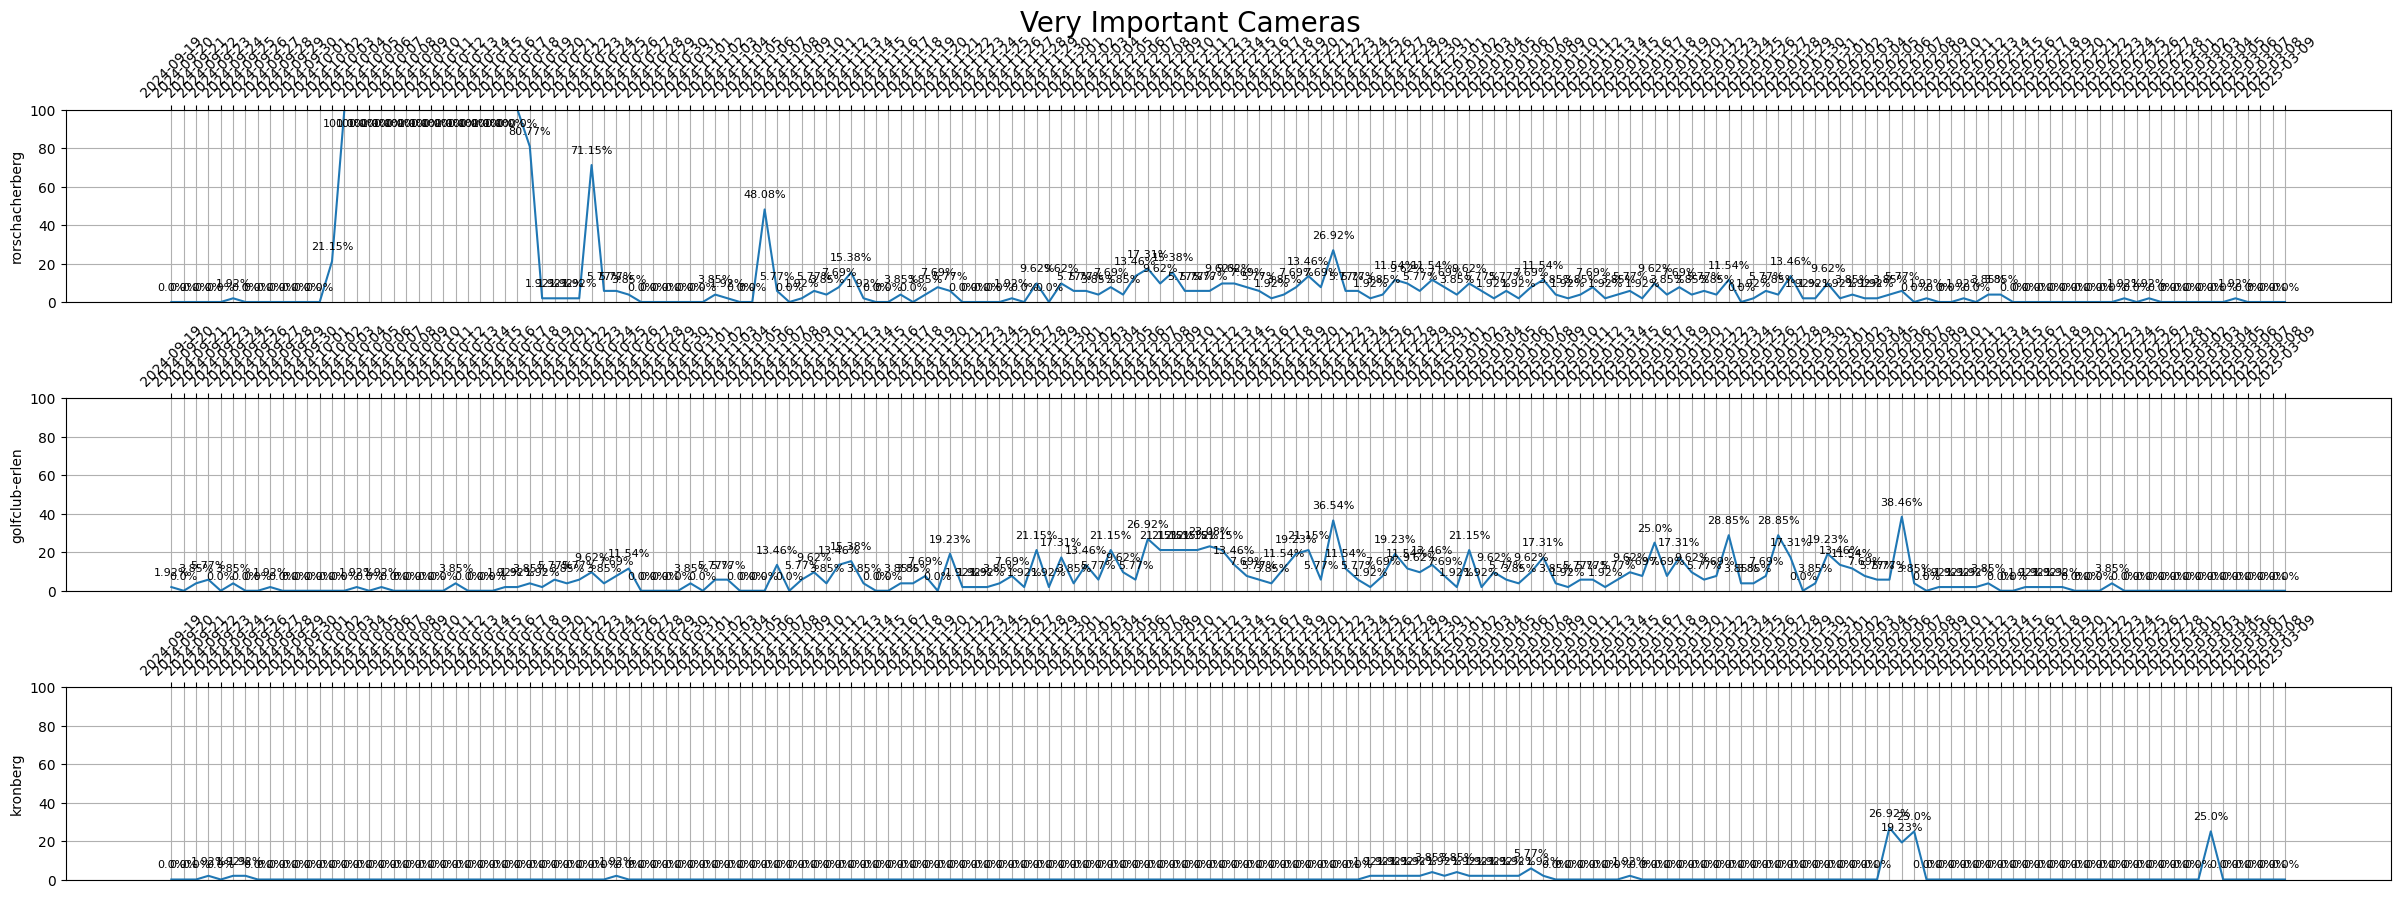

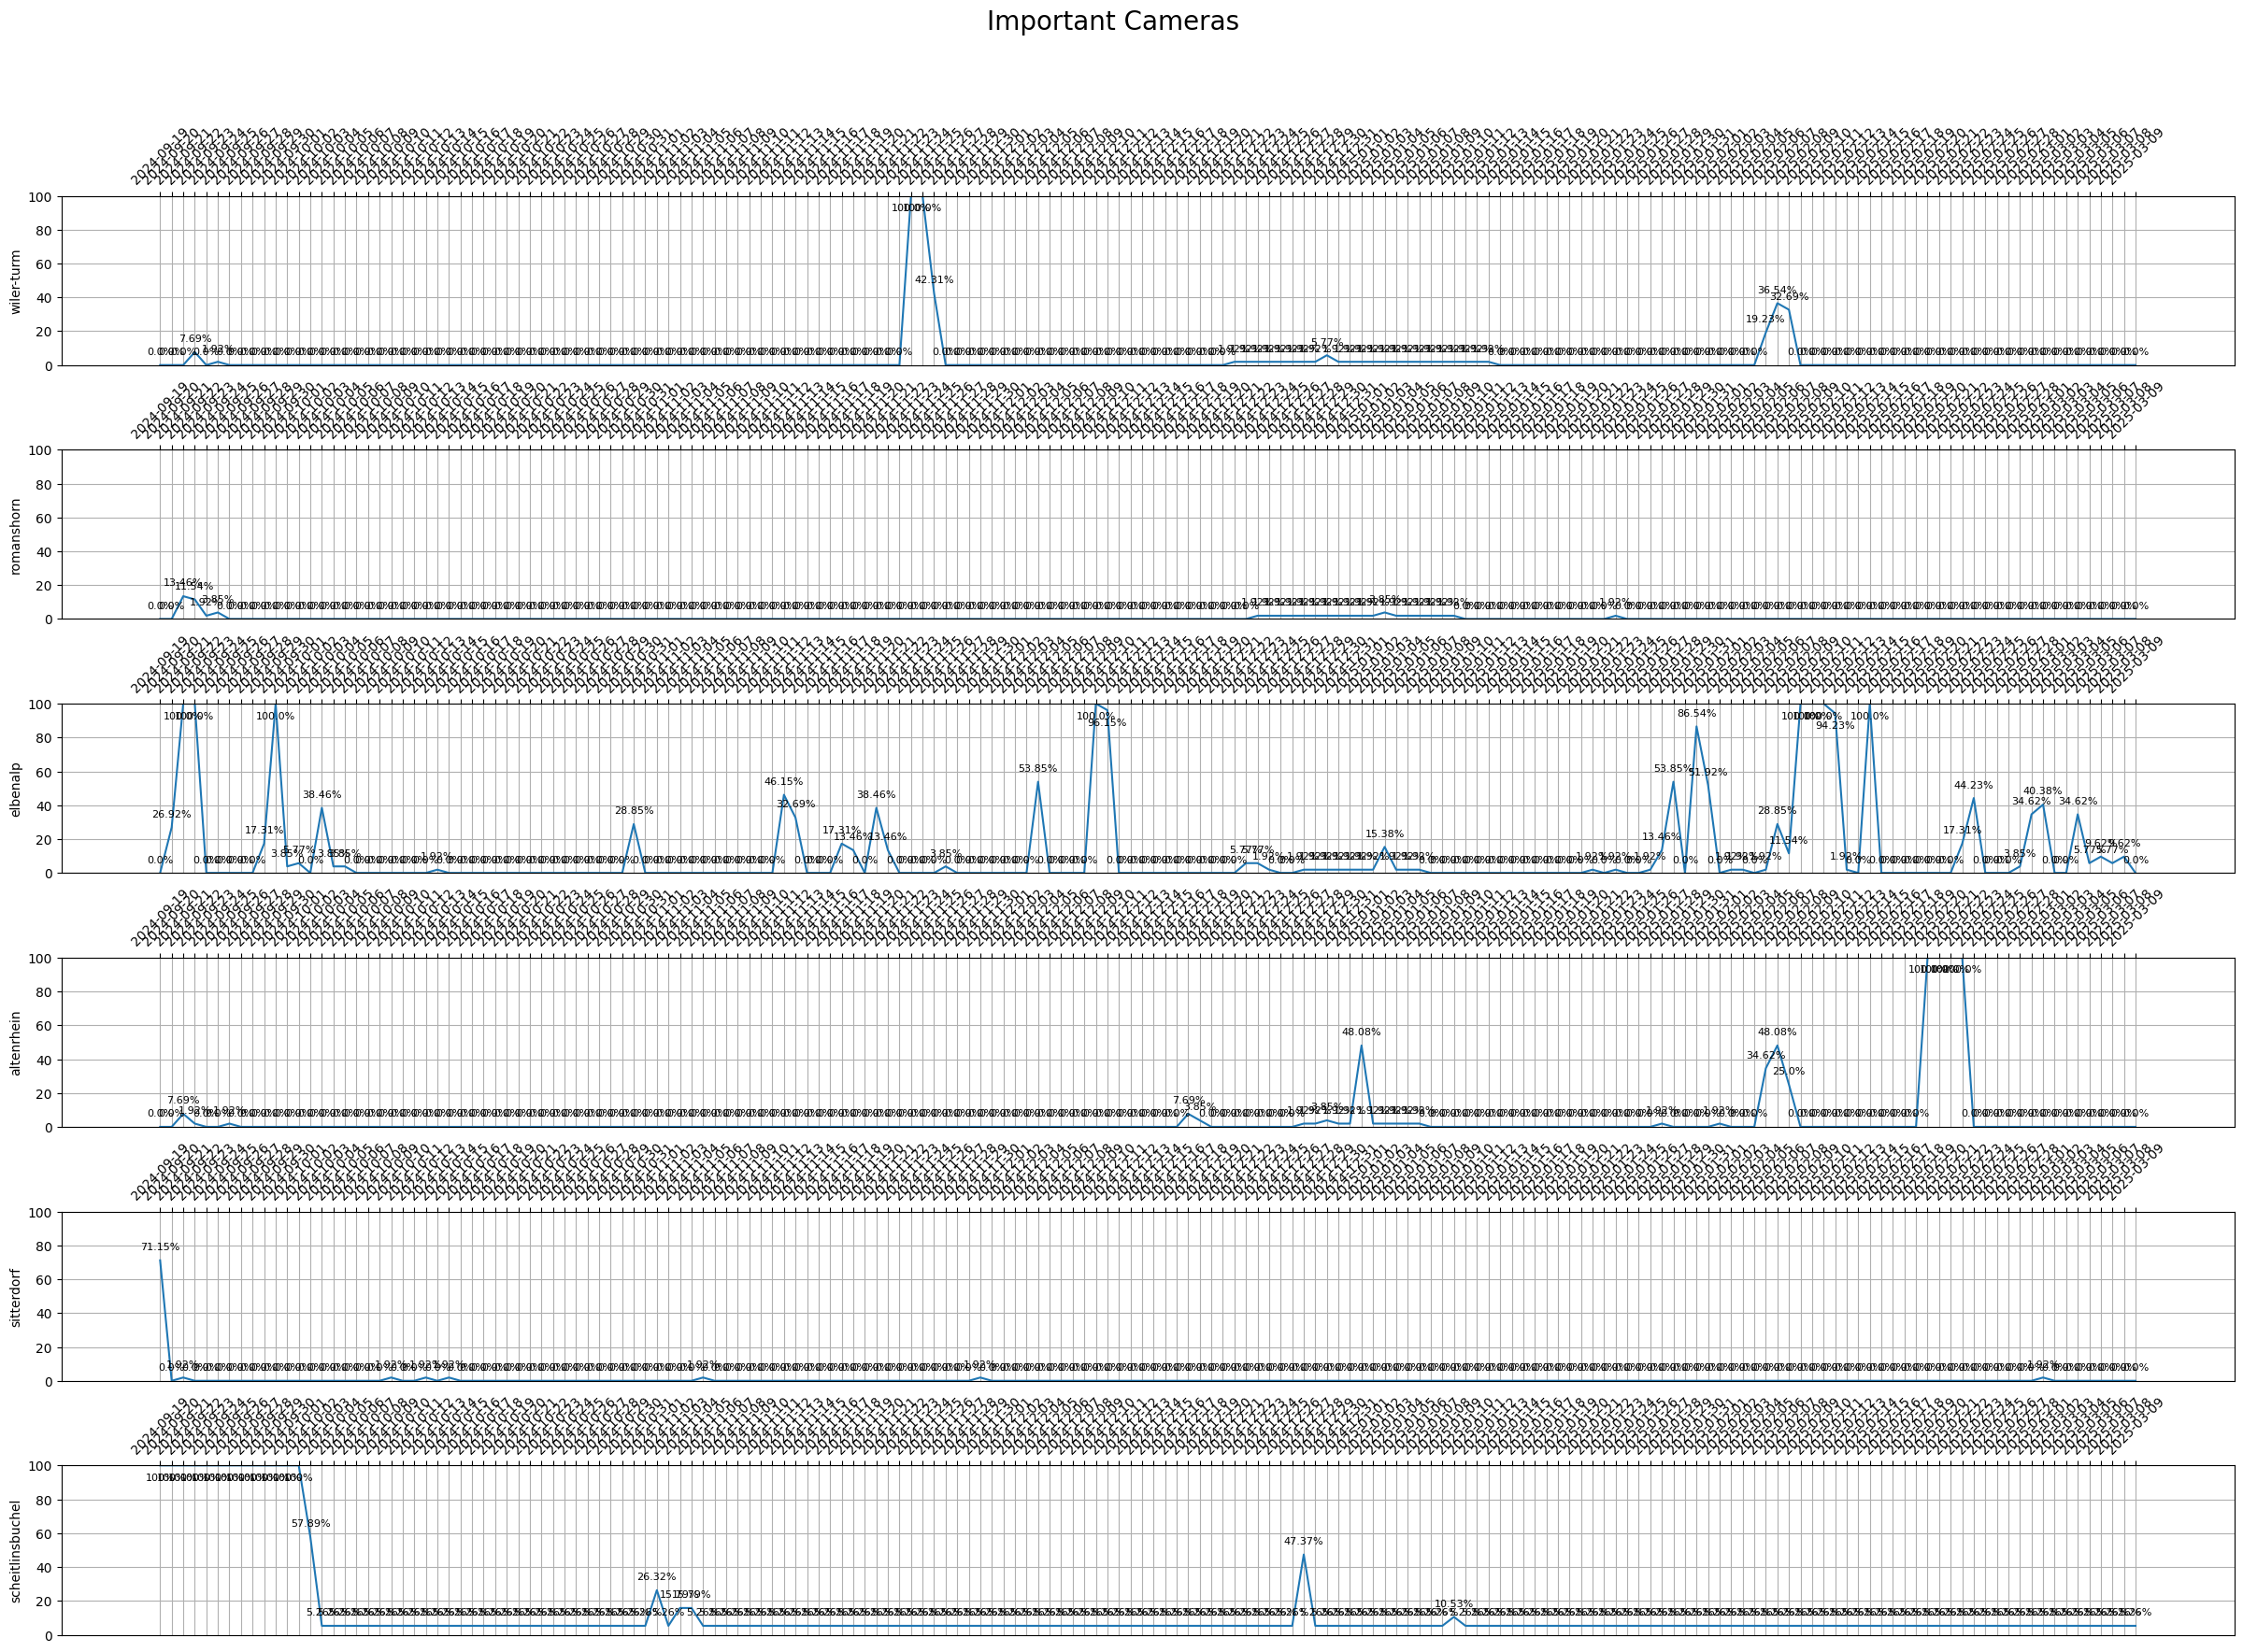

In [23]:
other_folders = [folder for folder in folders if folder not in very_important_folders and folder not in important_folders]

# Function to plot for a given category
def plot_webcams(folders_list, category_name, size=(20, 4)):
    num_webcams = len(folders_list)
    if num_webcams == 0:
        return  # If no webcams in this category, skip plotting
    
    fig, axes = plt.subplots(num_webcams, 1, figsize=size, sharex=True)
    if num_webcams == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        folder_index = folders.index(folders_list[i])  # Get index of the folder in the original data
        ax.plot(days, effective_missing_per_webcam[folder_index])
        ax.set_xticks(days)
        ax.set_xticklabels(days, rotation=45)
        
        
        # Include data labels
        for x, y in zip(days, effective_missing_per_webcam[folder_index]):
            delta = 5 if y < 90 else -10
            ax.text(x, y + delta, f'{y}%', fontsize=8, ha='center', va='bottom')
        
        ax.set_ylabel(f'{folders_list[i]}')  # Label y-axis with the camera's name
        ax.set_ylim([0, 100])
        ax.grid(True)

        # add space between subplots
        plt.subplots_adjust(hspace=0.5)
    
    for ax in axes:
        ax.xaxis.set_ticks_position('top')
    
    plt.suptitle(f'{category_name} Cameras', fontsize=20)
    plt.show()

# Plot for each category
plot_webcams(very_important_folders, 'Very Important', (30, 10))
plot_webcams(important_folders, 'Important',  (30, 20))
# plot_webcams(other_folders, 'Other',  (20, 80))